# Interpret the Embedding Space

**helical-ai:** Analyze the effects of the perturbations by visualizing and interpreting the resulting
embedding space. Consider metrics such as clustering, shifts in embedding coordinates,
and neighborhood analysis to infer the impact of perturbations on tumor gene networks.

**Titouan:** Since I spent so much time on step 2, I didn't have as much time as I would have liked for this step. I decided to get a general look at the embeddings using UMAP first and then t-SNE. Next, I trained a KNN algorithm on the tumor and healthy tissues and evaluated how it predicted the perturbed healthy and tumor states. If the algorithm predicted the healthy perturbed samples as tumor and the tumor perturbed samples as healthy, it would be a good indication that our in-silico perturbation was somewhat successful.

## 1) Imports

In [1]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

2024-12-03 21:38:53.684068: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 21:38:53.810483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 21:38:53.842735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 21:38:53.853505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 21:38:53.927600: I tensorflow/core/platform/cpu_feature_guar

## 2) Loading embeddings & metadata

In [2]:
embeddings = np.load("embeddings_full.npy")
embeddings

array([[-0.00966178,  0.00028845,  0.05551311, ..., -0.03750867,
         0.02094728, -0.0534763 ],
       [-0.00188298, -0.00192133,  0.07942488, ..., -0.00246671,
        -0.00121853, -0.03497089],
       [-0.01936999,  0.01553321,  0.07892258, ..., -0.01176252,
         0.01961049, -0.0402434 ],
       ...,
       [-0.02025982,  0.0017828 ,  0.0498505 , ..., -0.01916908,
         0.0106148 , -0.0446007 ],
       [ 0.00053532,  0.01570459,  0.08112805, ..., -0.01300089,
        -0.01150124, -0.03836003],
       [-0.04217244, -0.00798907,  0.06208811, ..., -0.01174584,
        -0.02724068, -0.02172413]], dtype=float32)

In [3]:
tissue_info = pd.read_csv("embedding_full_tissue_info.csv", index_col=0)
tissue_info

,tissue
0,3
1,3
2,3
3,3
4,1
...,...
995,2
996,2
997,3
998,3


## 3) Visualising & quantifying shifts in embedding space

### 3.1) Umap

Let's use umap to get a better look at what our final embeddings look like.

In [4]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None,n_neighbors=3)
mapper = reducer.fit(embeddings)

Text(0.5, 1.0, 'UMAP of Reference Data only Healthy')

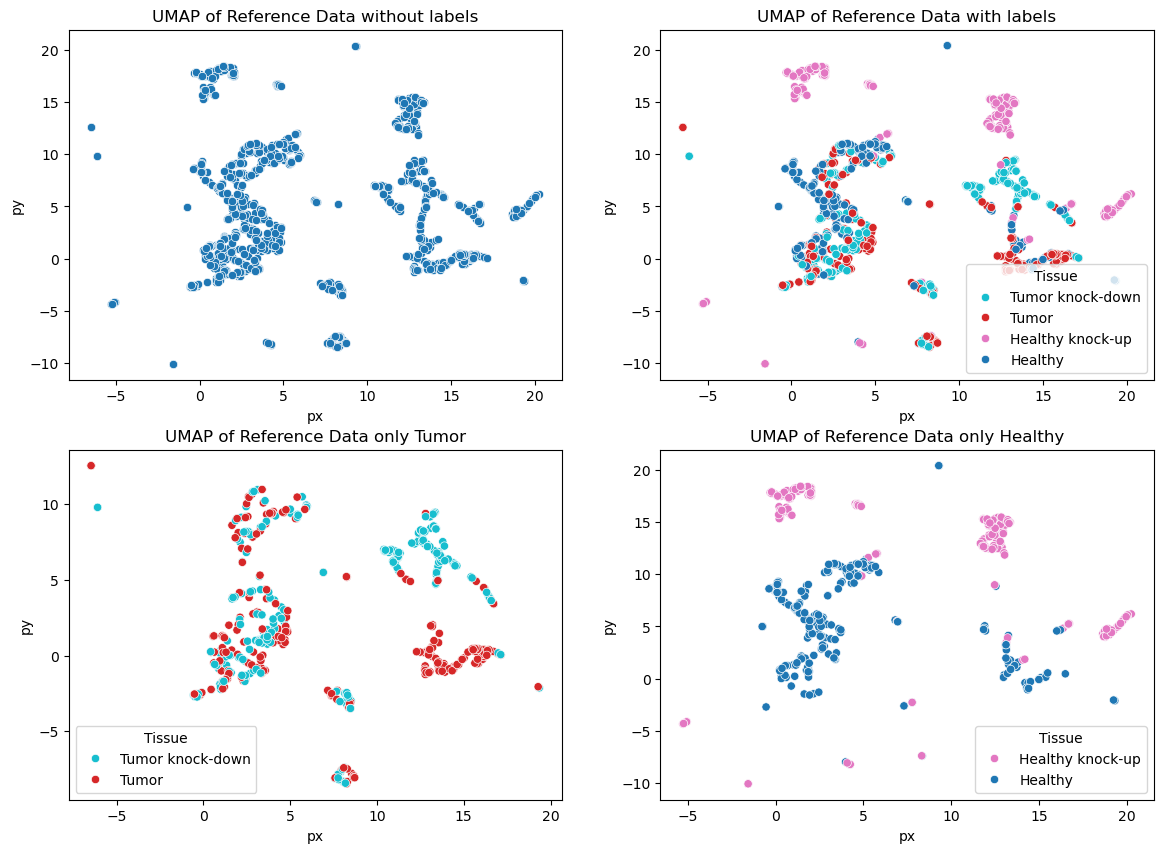

In [5]:
plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
labels = tissue_info[:len(embeddings)].values
correspondence = {0: "Healthy", 1: "Tumor", 2: "Healthy knock-up", 3: "Tumor knock-down"}
plot_df['Tissue'] = np.vectorize(correspondence.get)(labels)

custom_palette = {"Tumor": "#d62728", "Healthy": "#1f77b4", "Tumor knock-down": "#17becf", "Healthy knock-up": "#e377c2"}

# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0][0])
axs[0][0].set_title('UMAP of Reference Data without labels')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Tissue',sizes=(50,200),ax=axs[0][1],palette=custom_palette)
axs[0][1].set_title('UMAP of Reference Data with labels')

sns.scatterplot(data = plot_df[plot_df['Tissue'].isin(["Tumor", "Tumor knock-down"])],x='px',y='py',hue='Tissue',sizes=(50,200),ax=axs[1][0],palette=custom_palette)
axs[1][0].set_title('UMAP of Reference Data only Tumor')

sns.scatterplot(data = plot_df[plot_df['Tissue'].isin(["Healthy", "Healthy knock-up"])],x='px',y='py',hue='Tissue',sizes=(50,200),ax=axs[1][1],palette=custom_palette)
axs[1][1].set_title('UMAP of Reference Data only Healthy')

At first glance, the UMAP output is difficult to interpret, especially with four categories. However, in the plots with only healthy or only tumor, we clearly see the two groups emerging in different clusters.

### 3.2) t-SNE

In [6]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [7]:
standard_scaler = StandardScaler()

embeddings_normalized = standard_scaler.fit_transform(embeddings)

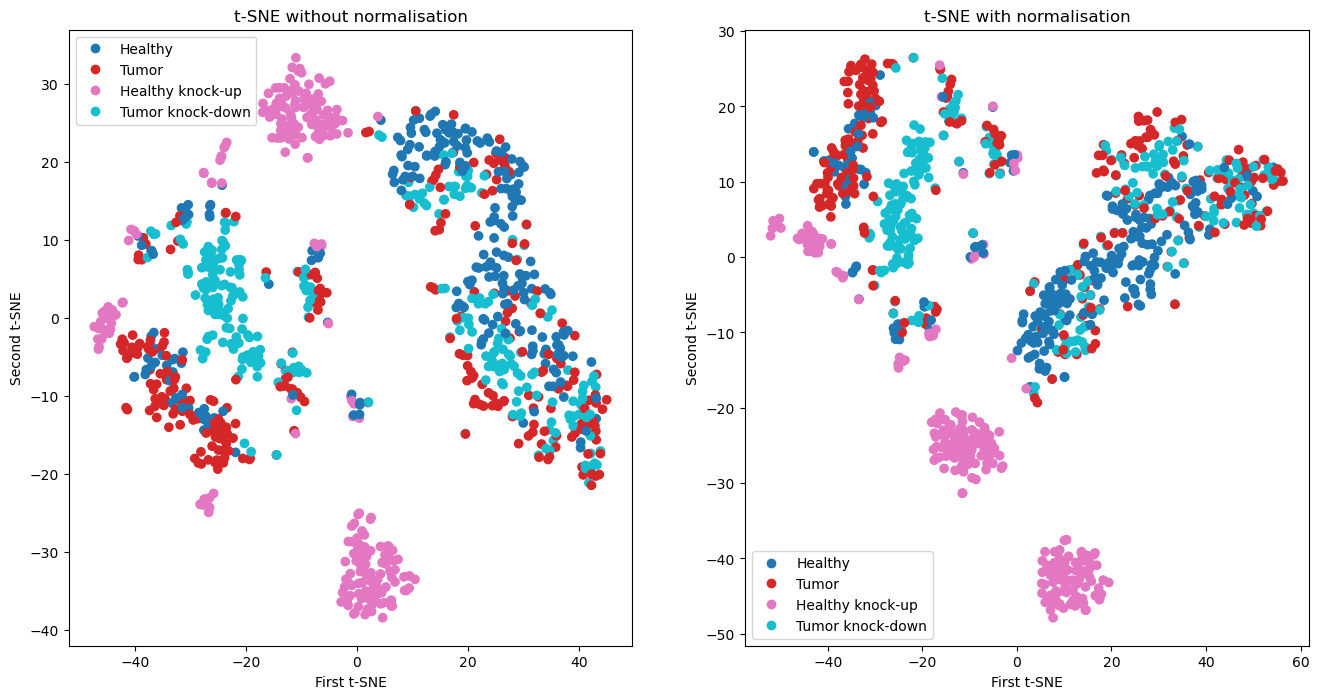

In [9]:
tsme = TSNE(n_components = 2).fit_transform(embeddings)
tsme_normalized = TSNE(n_components = 2).fit_transform(embeddings_normalized)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

_scatter = ax[0].scatter(tsme[:, 0], tsme[:, 1], c=labels, cmap='tab10')
ax[0].set_title("t-SNE without normalisation")
ax[0].set_xlabel('First t-SNE')
ax[0].set_ylabel('Second t-SNE')
legend_labels = ["Healthy", "Tumor", "Healthy knock-up", "Tumor knock-down"] 
_handles, _ = _scatter.legend_elements()
ax[0].legend(_handles, legend_labels)

_scatter = ax[1].scatter(tsme_normalized[:, 0], tsme_normalized[:, 1], c=labels, cmap='tab10')
ax[1].set_title("t-SNE with normalisation")
ax[1].set_xlabel('First t-SNE')
ax[1].set_ylabel('Second t-SNE')
legend_labels = ["Healthy", "Tumor", "Healthy knock-up", "Tumor knock-down"] 
_handles, _ = _scatter.legend_elements()
ax[1].legend(_handles, legend_labels)

plt.show()

On the t-SNE we can see different clusters emerging. Healthy knock-up and Healthy seem clearly differentiated however it's a bit more nebullous for Tumor vs Tumor knock-down.

### 3.3) Cossine similarity

In [10]:
original_healthy = embeddings[tissue_info['tissue'] == 0]
original_tumor = embeddings[tissue_info['tissue'] == 1]
shifted_healthy = embeddings[tissue_info['tissue'] == 2]
shifted_tumor = embeddings[tissue_info['tissue'] == 3]

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

cos_similarities = np.diag(cosine_similarity(original_healthy, shifted_healthy))
mean_shift = 1 - np.mean(cos_similarities)  # 1 - similarity as "distance"

print("Mean cosine shift healthy vs perturbed healthy:", mean_shift)

cos_similarities = np.diag(cosine_similarity(original_tumor, shifted_tumor))
mean_shift = 1 - np.mean(cos_similarities)  # 1 - similarity as "distance"

print("Mean cosine shift tumor vs perturbed tumor:", mean_shift)

cos_similarities = np.diag(cosine_similarity(original_healthy, original_tumor))
mean_shift = 1 - np.mean(cos_similarities)  # 1 - similarity as "distance"

print("Mean cosine shift healthy vs tumor:", mean_shift)

Mean cosine shift healthy vs perturbed healthy: 0.03546780347824097
Mean cosine shift tumor vs perturbed tumor: 0.035985708236694336
Mean cosine shift healthy vs tumor: 0.03238743543624878


All three shifts are relatively small, indicating that the groups are not drastically different from each other in terms of cosine similarity. However, it’s interesting to note that the difference in cosine shift between the original and perturbed states is slightly larger than the shift between healthy and tumor, suggesting that our perturbation algorithm is successfully influencing the final embedding of the gene expression data.

### 4) KNN

Finally, I wanted to test whether KNN algorithms could predict knocked-up healthy and knocked-down tumor samples as tumor and healthy respectively. For example, if a knocked-up healthy sample no longer registers as healthy, it would indicate that our perturbation algorithm has successfully and significantly altered the cell's state.

In [12]:
embeddings = np.load("embeddings.npy")
tissue_info = pd.read_csv("embedding_tissue_info.csv", index_col=0)
labels = tissue_info[:len(embeddings)].values

In [13]:
modified_embeddings = embeddings.copy()
modified_labels = labels.copy()
for i in range(len(labels) - 1, -1, -1):
    if labels[i] >= 2:
        modified_labels = np.delete(modified_labels, i, axis=0)
        modified_embeddings = np.delete(modified_embeddings, i, axis=0)
print(len(modified_embeddings))
print(len(modified_labels))

503
503


In [14]:
# Cosine similarity
neigh = KNeighborsClassifier(n_neighbors=5, metric='cosine')
neigh.fit(modified_embeddings, modified_labels.ravel())

KNeighborsClassifier(metric='cosine')

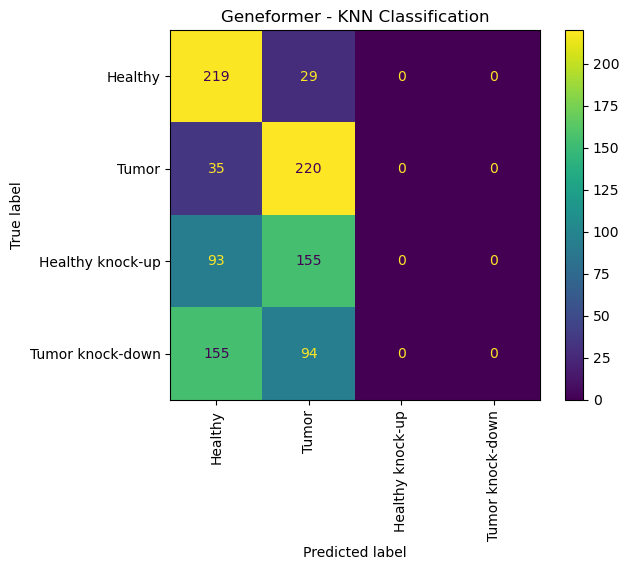

In [15]:
pred_labels = neigh.predict(embeddings)
cm = confusion_matrix(labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Tumor", "Healthy knock-up", "Tumor knock-down"] )
disp.plot(xticks_rotation="vertical")
plt.title("Geneformer - KNN Classification")
plt.show()

This result is highly promising, as it demonstrates that we are able to perturb the genes of the cells and induce a targeted change in their state. This suggests that our perturbation approach is effective in manipulating the cellular environment in a controlled manner, potentially opening the door to more precise interventions in gene expression.